# Importing Libraries

In [2]:
import cv2
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
import os
from centroidtracker import CentroidTracker

# Creating Frames(Images) from Video

In [3]:
path1="D:/Project/Input_Images/"
count = 0
video = "D:/Project/Videos/Original Video.mp4"
capture_frame = cv2.VideoCapture(video)   
while(capture_frame.isOpened()):
    frame_Id = capture_frame.get(cv2.CAP_PROP_POS_FRAMES)  
    ret, frame = capture_frame.read()  
    if (ret != True):
        break
    if frame_Id%10==0:
        file_name ="frame"+str(count)+".jpg" 
        count+=1
        cv2.imwrite(path1+str(file_name), frame)     
capture_frame.release()
print ("Created all the Images!!")

Created all the Images!!


# Checking for a Frame(Image)

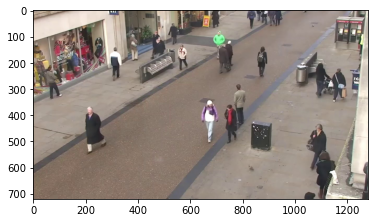

In [4]:
img = plt.imread(path1+'frame0.jpg')  
plt.imshow(img)

In [5]:
listing  = os.listdir(path1)
count_frames=len(listing)
count_frames

165

# COCO Dataset, Pre-defined Weights and Output Layers

In [6]:
coco_labels = open('D:/Project/setup_files/coco.names').read().strip().split('\n') 
weightsPath = 'D:/Project/setup_files/yolov3.weights'
configPath = 'D:/Project/setup_files/yolov3.cfg'

COLORS = np.random.randint(0, 255, size=(len(coco_labels), 3),dtype="uint8")

Io_U = 0.5  
NMS = 0.3   

net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)  
layers = net.getLayerNames()

outputlayers=[]
for i in net.getUnconnectedOutLayers():
    outputlayers.append(layers[i[0]-1])
print(outputlayers)

['yolo_82', 'yolo_94', 'yolo_106']


# Coordinates of People

In [7]:
def person_info(zero_classids,classIDs,i,filtered_heights,boxes,xycoord,x,y,w,h,color1,color):
    zero_classids.append(classIDs[i])
    filtered_heights.append(boxes[i][3])
    xycoord.append((x,y,w,h))
    color1.append(color)
    return filtered_heights,zero_classids,xycoord,color1

# Draw the Centroid between the Bounding Boxes

In [8]:
def draw_center(image,x,y,w,h):
    center=(int(x+(w/2)),int(y+(h/2)))
    cv2.circle(image,center,0,(0,255,0),2)
    return image,center

# Calculation of Boxes, Confidences and their Classes

In [9]:
def calculate_boxes(detected_scores,Io_U):
    classes = detected_scores[5:]
    classID = np.argmax(classes)
    confidence = classes[classID]
    if confidence > Io_U:
        box = detected_scores[0:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = box.astype("int")
        x = int(centerX - (width / 2))  
        y = int(centerY - (height / 2))  
        boxes.append([x, y, int(width), int(height)])
        confidences.append(float(confidence))
        classIDs.append(classID)
    return boxes,confidences,classIDs

# Creating Bounding Boxes regarding their distance

In [10]:
def groupBoundingBoxes(image, xycoord, min_x,min_y,v):
    for b in range(0, len(xycoord)):
        for c in range(0, len(xycoord)):
            if abs(xycoord[b][0]-xycoord[c][0])<=min_x:
                if abs(xycoord[b][1]-xycoord[c][1])<=min_y:
                    if b !=c:
                        x,y,w,h=xycoord[b][0],xycoord[b][1],xycoord[b][2],xycoord[b][3]
                        p,q,r,s=xycoord[c][0],xycoord[c][1],xycoord[c][2],xycoord[c][3]
                        v.append((x,y,p+r,q+s))
    return image,v

In [11]:
def group_detection(v,wid):
    for d in range(0,len(v)):
        width = v[d][2]-v[d][0]
        height = v[d][3]-v[d][1]
        wid.append((width,height))
    for e in range(0,len(v),2):
        text3="Group"
        if wid[e][0]*wid[e][1]>wid[e+1][0]*wid[e+1][1]:
            cv2.putText(image, text3, (v[e][0], v[e][1] +30), cv2.FONT_HERSHEY_SIMPLEX,0.5,(204, 51, 153), 2)
            cv2.rectangle(image, (v[e][0], v[e][1]), (v[e][2], v[e][3]), (255,255,0), 2) 
        else:
            cv2.putText(image, text3, (v[e+1][0], v[e+1][1] +30), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255,255,0), 2)
            cv2.rectangle(image, (v[e+1][0], v[e+1][1]), (v[e+1][2], v[e+1][3]), (255,255,0), 2)

# Object Tracking (Movement of Objects) and Overall Count of People

In [12]:
def object_tracker(object_id_list,total_count,image):
    for (objectId, bbox) in objects.items():
        x1, y1, w2, h2 = bbox
        x1 = int(x1)
        y1 = int(y1)
        w1 = int(w2)
        h1 = int(h2)
 
        if objectId not in object_id_list:
            object_id_list.append(objectId)
        
    total_count = len(object_id_list)
    total_count = "Total Count of Persons: {}".format(total_count)
    
    cv2.putText(image, total_count, (5, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)
    return image,object_id_list

# Main Program which are iterating the Images and Functions

In [13]:
data={}
min_x,min_y=60,40
tracker = CentroidTracker(maxDisappeared=80, maxDistance=90)
object_id_list = []
total_count = 0  

for a in range(0,count_frames):
    image = cv2.imread(path1+'frame' + str(a)+".jpg")
    (H, W) = image.shape[:2]
    
    #Preprocessing of Image
    preprocessed_image = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False) 
    net.setInput(preprocessed_image)
    weights_outputlayers = net.forward(outputlayers)   
    
    boxes = []   
    confidences = []
    classIDs = []   
    
    #Calculate all Possible Bounding Boxes
    for layer in weights_outputlayers:
        for detected_scores in layer:
            calculate_boxes(detected_scores,Io_U)
    
    zero_classids=[]     
    filtered_heights=[]   
    xycoord=[]            
    color1=[]
    
    #Creating Bounding Boxes based on NMS Value
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, Io_U, NMS)
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y,w,h) = (boxes[i][0], boxes[i][1],boxes[i][2], boxes[i][3])
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.2f}".format(coco_labels[classIDs[i]], (confidences[i]*100))
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, (24, 36, 61), 2)

            if classIDs[i]==0:
                person_info(zero_classids,classIDs,i,filtered_heights,boxes,xycoord,x,y,w,h,color1,color)
                draw_center(image,x,y,w,h)
 
    objects = tracker.update(xycoord)
    object_tracker(object_id_list,total_count,image)
    
    v=[]
    wid=[]
    child=0
    adult=0
    
    # Checking the Age Group Category
    for person in range(0,len(zero_classids)):
        if filtered_heights[person]<(sum(filtered_heights)/len(filtered_heights))/1.5:
            text1="Child"
            child+=1
            x,y=xycoord[person][0],xycoord[person][1]
        else:
            text1="Adult"
            adult+=1
            x,y=xycoord[person][0],xycoord[person][1]
        cv2.putText(image, text1, (x, y +10), cv2.FONT_HERSHEY_SIMPLEX,0.5, color1[person], 2)
    
    #Storing in a Dataframe to create CSV
    fname="frame"+str(a)
    data[fname]=[len(object_id_list),adult+child,adult,child]
    
    #Creating Group Bounding Boxes
    groupBoundingBoxes(image, xycoord, min_x,min_y,v)
    group_detection(v,wid)
    
    #Storing the images in another folder
    path2="D:/Project/Output_Images/"
    filename=(path2+'output'+str(a)+'.jpg')
    cv2.imwrite(filename,image)
print("Done")

Done


# Creating a Video from Processed Images

In [14]:
img=[]
for i in range(0,count_frames):
    img1=cv2.imread(path2+'output'+str(i)+'.jpg')
    height,width,layers=img1.shape
    img.append(img1)

video = cv2.VideoWriter('Output_Video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (width,height))

for j in range(0,count_frames):
    video.write(img[j])

cv2.destroyAllWindows()
video.release()

# Saving the data in CSV File 

In [15]:
#Saving data containing Overall Person Count, Count of Persons in a Frame, Count of Adult and Chind in a frame.
df=pd.DataFrame.from_dict(data,orient='index',columns=['Overall Person Count','Person Count in Frame','Adult Count','Child Count'])
df.to_csv("Data.csv")

ValueError: 3 columns passed, passed data had 4 columns